Удалила "2 Зрелый почерк-(обычный почерк)-2.jpg" (там печатный текст)

# Config

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/Colab\ Notebooks/mest

/content/drive/MyDrive/Colab Notebooks/mest


In [3]:
!pip install hydra-core --upgrade

In [4]:
from src.commands import *
import hydra

hydra.core.global_hydra.GlobalHydra.instance().clear()
CONF = hydra_config("config4.yaml")
show_CONF(CONF)

{
        "seed": 42,
        "device": "cuda",
        "save_path": "checkpoints",
        "dataset": {
                "data_pos": "bin/1",
                "data_neg": "bin/0",
                "threshold": 0.999,
                "pos_aug": 22,
                "neg_aug": 2
        },
        "loader": {
                "batch_size": 8
        },
        "siamese": {
                "n_epochs": 50,
                "learning_rate": 0.001,
                "margin": 9,
                "train": true,
                "path_model": "siamese_pre",
                "path_log": "siamese_pre.pickle"
        },
        "classifier": {
                "n_epochs": 30,
                "learning_rate": 0.0001,
                "train": true,
                "path_model": "classifier_pre",
                "path_log": "classifier_pre.pickle"
        }
}


In [5]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
CONF3 = hydra_config("config3.yaml")
show_CONF(CONF3)

{
        "seed": 42,
        "device": "cuda",
        "save_path": "checkpoints",
        "loader": {
                "batch_size": 64
        },
        "siamese": {
                "n_epochs": 100,
                "learning_rate": 0.001,
                "margin": 9,
                "train": true,
                "path_model": "pretrain",
                "path_log": "pretrain.pickle"
        }
}


In [6]:
show_CONF(CONF)
show_CONF(CONF3)

{
        "seed": 42,
        "device": "cuda",
        "save_path": "checkpoints",
        "dataset": {
                "data_pos": "bin/1",
                "data_neg": "bin/0",
                "threshold": 0.999,
                "pos_aug": 22,
                "neg_aug": 2
        },
        "loader": {
                "batch_size": 8
        },
        "siamese": {
                "n_epochs": 50,
                "learning_rate": 0.001,
                "margin": 9,
                "train": true,
                "path_model": "siamese_pre",
                "path_log": "siamese_pre.pickle"
        },
        "classifier": {
                "n_epochs": 30,
                "learning_rate": 0.0001,
                "train": true,
                "path_model": "classifier_pre",
                "path_log": "classifier_pre.pickle"
        }
}
{
        "seed": 42,
        "device": "cuda",
        "save_path": "checkpoints",
        "loader": {
                "batch_size": 64
        },
     

# Библиотеки

In [7]:
from hydra import compose, initialize
from omegaconf import OmegaConf

import json, os
import matplotlib.pyplot as plt

from torchvision import datasets, models, transforms
from time import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
import os, json, cv2, re
import numpy as np
import random

from src.dataset import My_Dataset, TripletDataset, Emb_Dataset
from src.functions import number_of_parameters, seed_everything, create_model
from src.dataset_fun import split_dataset
from src import siamese, classifier
from src.classifier import get_predictions
from src.train import train, load_logs, load_model
from src.functions import confusion_matrix, distribution
from src.show_fun import show_result, show_images

In [8]:
class TripletMultiDataset(Dataset):
    def __init__(self, images_dir, required_len, deterministic=True, seed=42):
        self.images_dir = images_dir
        self.required_len = required_len
        self.deterministic = deterministic

        self.dirs_more_one = []
        self.dirs_other = []

        for dirpath, dirnames, filenames in os.walk(images_dir):

            if len(filenames) > 1:
                self.dirs_more_one.append(dirpath)
            elif len(filenames) == 1:
                self.dirs_other.append(dirpath)

        self.transform = transforms.Compose(
        [
            transforms.RandomCrop(300),
            # transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )

        if self.deterministic:
            seed_everything(seed)
            self.X = []
            for i in tqdm(range(self.required_len)):

                idx = random.randrange(len(self.dirs_more_one))
                dir = self.dirs_more_one[idx]
                files = os.listdir(dir)

                anchor, positive = random.sample(files, 2)
                anchor, positive = os.path.join(dir, anchor), os.path.join(dir, positive)



                dirs = self.dirs_more_one[:idx] + self.dirs_more_one[idx+1:] + self.dirs_other
                dir = random.choice(dirs)
                files = os.listdir(dir)
                negative = os.path.join(dir, random.choice(files))


                l = [anchor, positive, negative]

                # print(l)
                for i, path in enumerate(l):
                    image = Image.open(path)
                    l[i] = self.transform(image)

                self.X.append(l)


    def __len__(self):
        return self.required_len

    def __getitem__(self, idx):
        if idx < len(self):

            if self.deterministic:
                return self.X[idx]
            else:
                pass
        else:
            raise IndexError

In [9]:
dataset = torch.load('dataset.pt')

seed_everything(CONF.seed)
train_dataset, test_dataset = split_dataset(dataset)

split_dataset: Train: 800 Test: 200 Total: 1000


# train

[**TripletMarginLoss**
](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html)

$L(a,p,n)=max\{d(ai​,pi​)−d(ai​,ni​) + margin,0\}$

$d(x_i, y_i) = \|x_i − y_i\|_p$

[Contrastive learning](https://www.v7labs.com/blog/contrastive-learning-guide#:~:text=Contrastive%20Learning%20is%20a%20technique,a%20data%20class%20from%20another.)

[Contrastive learning](https://colab.research.google.com/drive/1uvXs3P1XsH7Mtc20kEI2D9cAPcg-cjyw?usp=sharing#scrollTo=_mmDxSSu19_e)

[Cиамские сети](https://habr.com/ru/articles/794750/)

[Cиамские сети](https://habr.com/ru/companies/jetinfosystems/articles/465279/)



In [10]:
pos_dataset, neg_dataset = pos_neg_dataset(CONF)

siam = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(CONF.device)
load_best_model(CONF3, siam, train_dataset, test_dataset, kind="siam") #####

num_classes = 1000
num_non_freeze = 513000
seed_everything(CONF.seed)
siam = create_model(siam, num_non_freeze, num_classes).to(CONF.device)
print(f"num parameters ResNet = {number_of_parameters(siam)}")

dataset1 = TripletDataset(
        pos_dataset, neg_dataset, required_len=1000, deterministic=True, seed=CONF.seed
    )
seed_everything(CONF.seed)
train_dataset, test_dataset = split_dataset(dataset1)

common_train(CONF, siam, train_dataset, test_dataset, kind="siam")
load_best_model(CONF, siam, train_dataset, test_dataset, kind="siam")

Positive dataset: 484    (22)
Negative dataset: 448    (224)
load_best_model:
LOGS:
# 2024-05-30 09:39:55 Epoch  39 train/val: loss 0.04586/0.62800, acc: 99.750%/ 97.000%
MODEL:
# 2024-05-30 09:40:01 Epoch  39 train/val: loss 0.04586/0.62800, acc: 99.750%/ 97.000%
num parameters ResNet = 513000
split_dataset: Train: 800 Test: 200 Total: 1000
train: started, kind = 'siam'
# 2024-05-30 09:40:09 Epoch  1 train/val: loss 8.30434/8.04539, acc: 60.500%/ 59.000%
# 2024-05-30 09:40:15 Epoch  2 train/val: loss 8.29670/7.51965, acc: 60.250%/ 66.000%
# 2024-05-30 09:40:23 Epoch  3 train/val: loss 9.13480/8.74844, acc: 59.625%/ 65.000%
# 2024-05-30 09:40:30 Epoch  4 train/val: loss 8.91289/8.78319, acc: 57.625%/ 59.500%
# 2024-05-30 09:40:37 Epoch  5 train/val: loss 7.49607/8.05020, acc: 62.875%/ 63.000%
# 2024-05-30 09:40:44 Epoch  6 train/val: loss 7.75980/7.97628, acc: 61.750%/ 63.000%
# 2024-05-30 09:40:51 Epoch  7 train/val: loss 7.86567/7.73642, acc: 62.750%/ 67.500%
# 2024-05-30 09:40:58 Ep

In [11]:
cl = nn.Sequential(nn.Linear(1000, 512), nn.ReLU(), nn.Linear(512, 2)).to(
    CONF.device
)
num_param = number_of_parameters(cl)
print(f"num parameters = {num_param}")

dataset = torch.utils.data.ConcatDataset([pos_dataset, neg_dataset])
dataset2 = Emb_Dataset(siam, dataset, CONF.device)
seed_everything(CONF.seed)
train_dataset, test_dataset = split_dataset(dataset2)

common_train(CONF, cl, train_dataset, test_dataset, kind="cl")
load_best_model(CONF, cl, train_dataset, test_dataset, kind="cl")

num parameters = 513538
split_dataset: Train: 745 Test: 187 Total: 932
train: started, kind = 'cl'
# 2024-05-30 09:46:12 Epoch  1 train/val: loss 0.52063/0.55173, acc: 73.960%/ 71.658%
# 2024-05-30 09:46:17 Epoch  2 train/val: loss 0.51206/0.59077, acc: 73.020%/ 72.193%
# 2024-05-30 09:46:23 Epoch  3 train/val: loss 0.54434/0.62812, acc: 70.201%/ 65.775%
# 2024-05-30 09:46:29 Epoch  4 train/val: loss 0.46377/0.53910, acc: 76.644%/ 70.053%
# 2024-05-30 09:46:34 Epoch  5 train/val: loss 0.48060/0.54390, acc: 74.899%/ 73.797%
# 2024-05-30 09:46:40 Epoch  6 train/val: loss 0.43815/0.52423, acc: 80.940%/ 71.123%
# 2024-05-30 09:46:45 Epoch  7 train/val: loss 0.44222/0.53011, acc: 78.121%/ 75.936%
# 2024-05-30 09:46:51 Epoch  8 train/val: loss 0.46386/0.54900, acc: 75.839%/ 71.658%
# 2024-05-30 09:46:56 Epoch  9 train/val: loss 0.42021/0.51992, acc: 79.732%/ 75.936%
# 2024-05-30 09:47:02 Epoch 10 train/val: loss 0.42403/0.54088, acc: 78.926%/ 73.797%
# 2024-05-30 09:47:08 Epoch 11 train/val:

In [15]:
def graph2(x, y1, y2, title="", ylog=True):
    plt.figure(figsize=(12, 6))
    plt.title(title, fontsize=13)

    plt.plot(x, y1, color='g', label = "Train")
    plt.plot(x, y2, color='m', label = "Test")

    plt.grid(True)
    plt.ylabel("loss",  fontsize=10)
    plt.xlabel("Номер итерации",  fontsize=10)

    if ylog:
        plt.yscale('log')

    plt.legend(fontsize=10)

    plt.show()

In [16]:
# graph2(logs['epoch'], logs['train_loss'], logs['val_loss'], title="")

In [17]:
# graph2(logs['epoch'], logs['train_accuracy'], logs['val_accuracy'], ylog = False)

# eval

In [18]:
class Pipeline(nn.Module):
    def __init__(self, model, cl):
        super().__init__()
        self.model = model
        self.cl = cl

    def forward(self, x):
        x = self.model(x.to(CONF.device))
        x = self.cl(x)
        return x

model = Pipeline(siam, cl)

0.9070247933884298


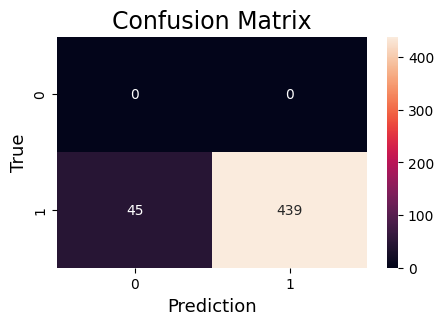

[[  0   0]
 [ 45 439]]


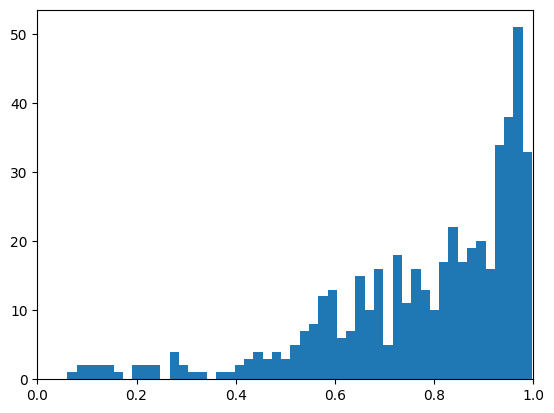

In [19]:
X, y_true, y_pred, y_prob = get_predictions(model, pos_dataset,
                                            CONF.loader.batch_size, CONF.device)
print(accuracy_score(y_pred, y_true))
# 0.987603305785124
# array([[  0,   0],
#        [  6, 478]])
print(confusion_matrix(y_true, y_pred))
distribution(y_prob)

0.7433035714285714


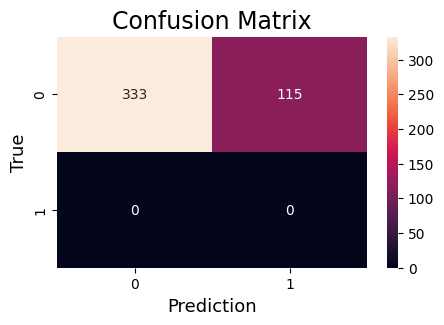

[[333 115]
 [  0   0]]


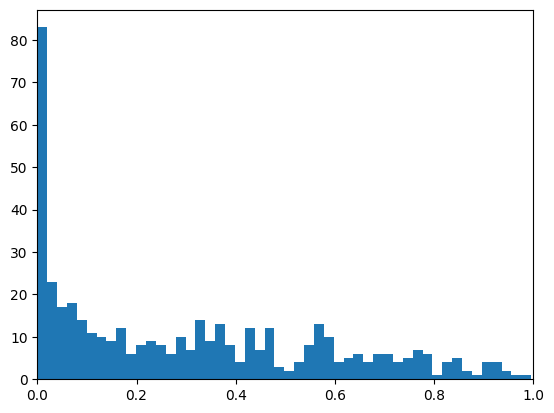

In [20]:
X, y_true, y_pred, y_prob = get_predictions(model, neg_dataset,
                                            CONF.loader.batch_size, CONF.device)
print(accuracy_score(y_pred, y_true))
# 0.96875
# array([[435,  13],
#        [  0,   0]])
print(confusion_matrix(y_true, y_pred))
distribution(y_prob)

0.8283261802575107


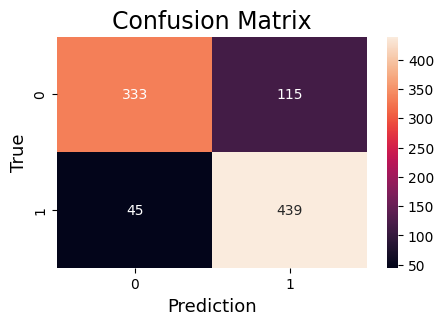

[[333 115]
 [ 45 439]]


In [21]:
X, y_true, y_pred, y_prob = get_predictions(model, dataset,
                                            CONF.loader.batch_size, CONF.device)
print(accuracy_score(y_pred, y_true))
print(confusion_matrix(y_true, y_pred))
# 0.9785407725321889
# array([[435,  13],
#        [  6, 478]])

# show

prob < 0.6
count : 86 out of 484
pic idx : [2, 190, 130, 85, 62, 59, 179, 121, 102, 169, 158, 14, 195, 183, 364, 420, 156, 419, 385, 375, 466, 165, 305, 166, 256, 4, 1, 123, 124, 42]


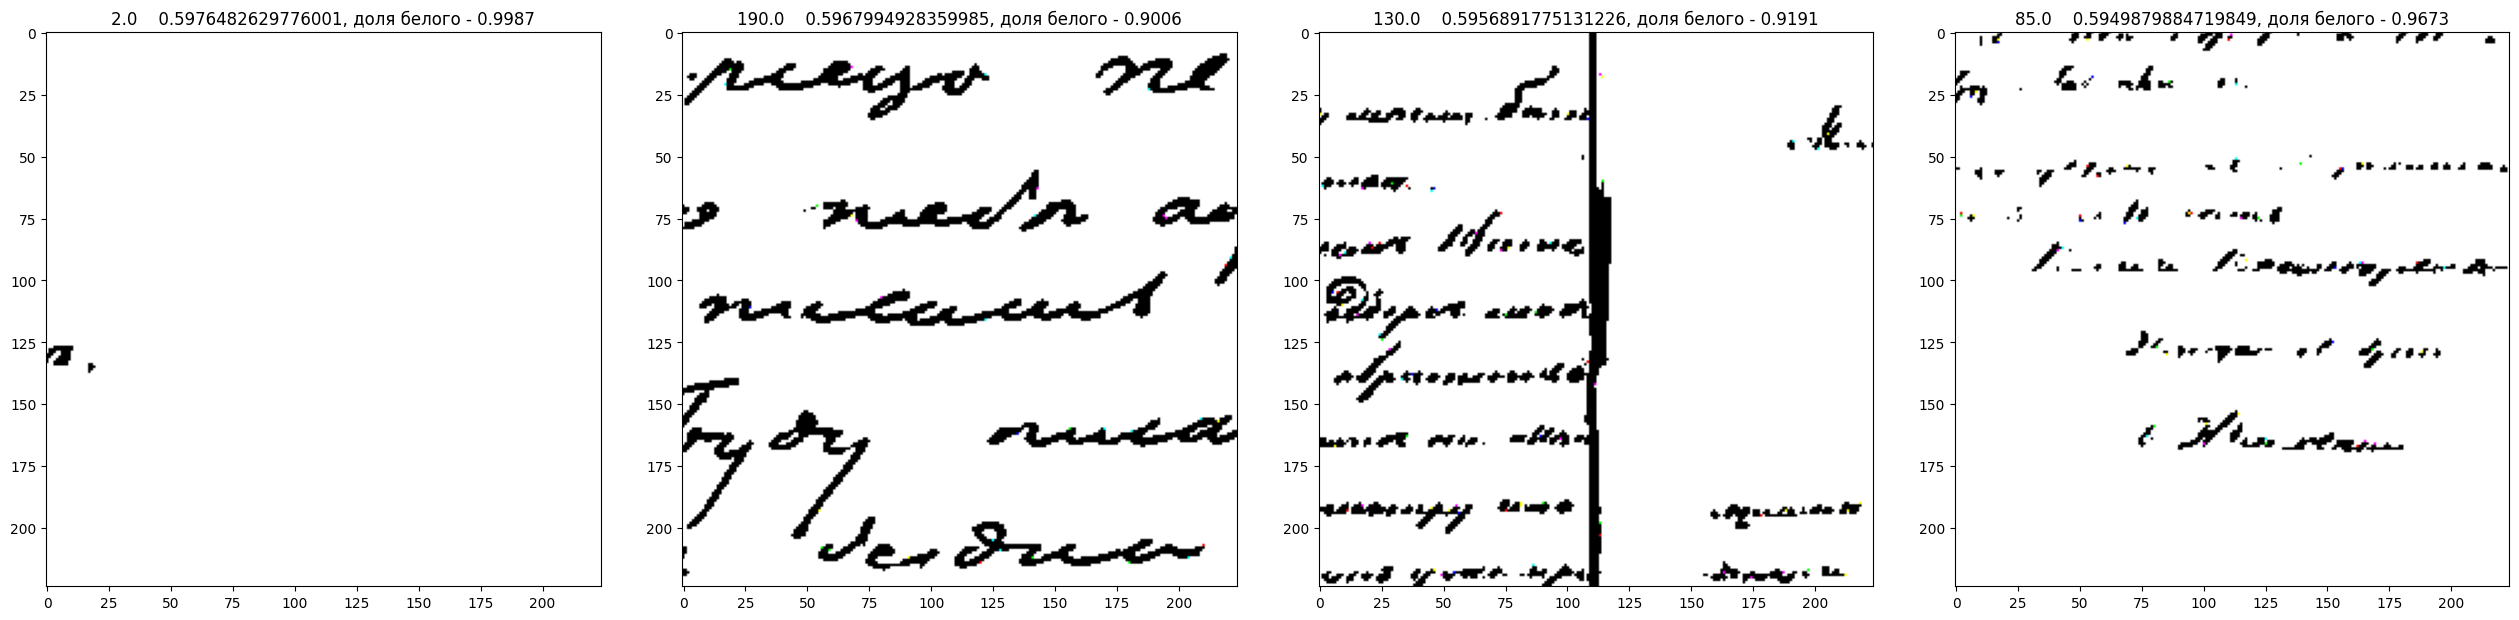

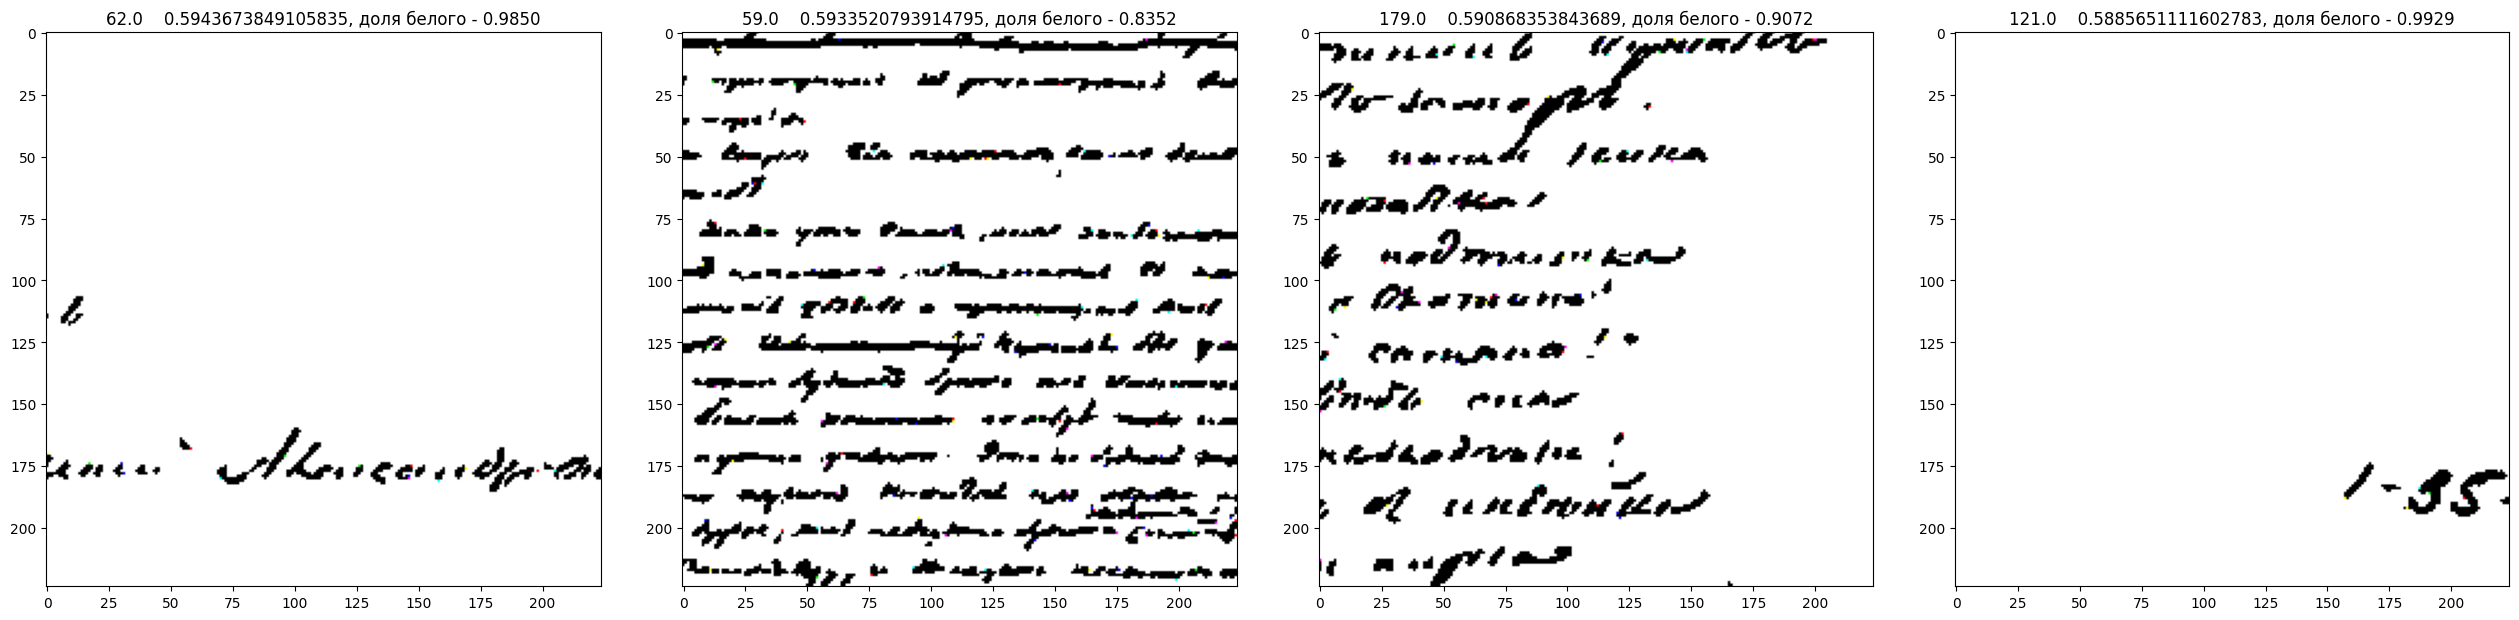

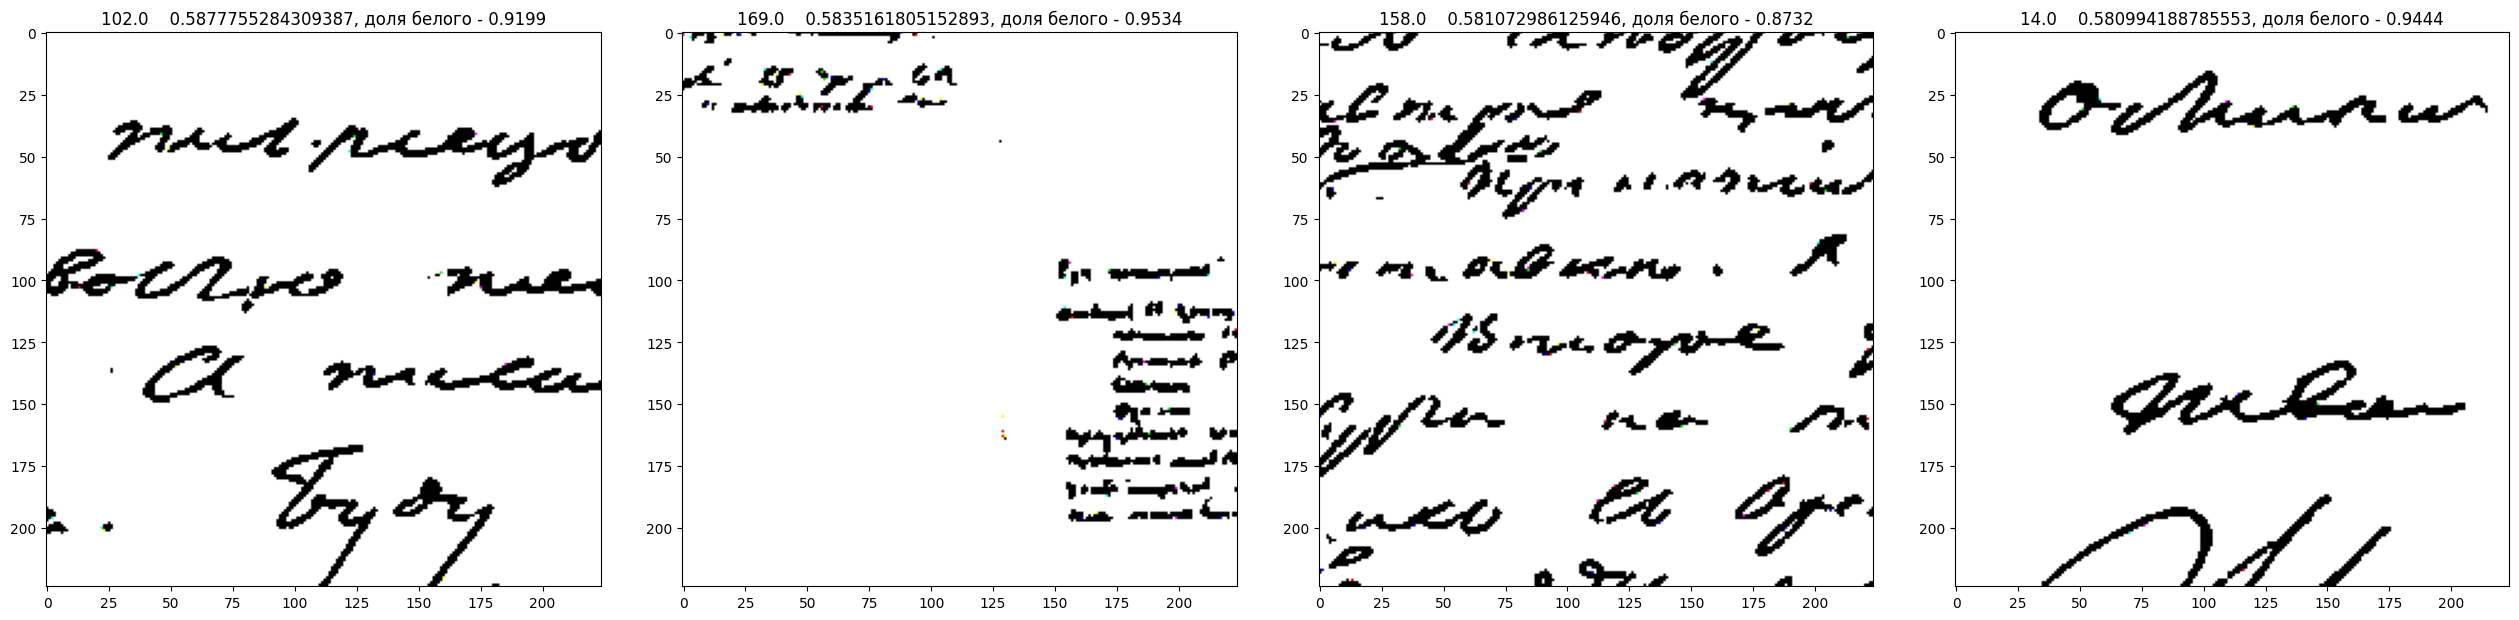

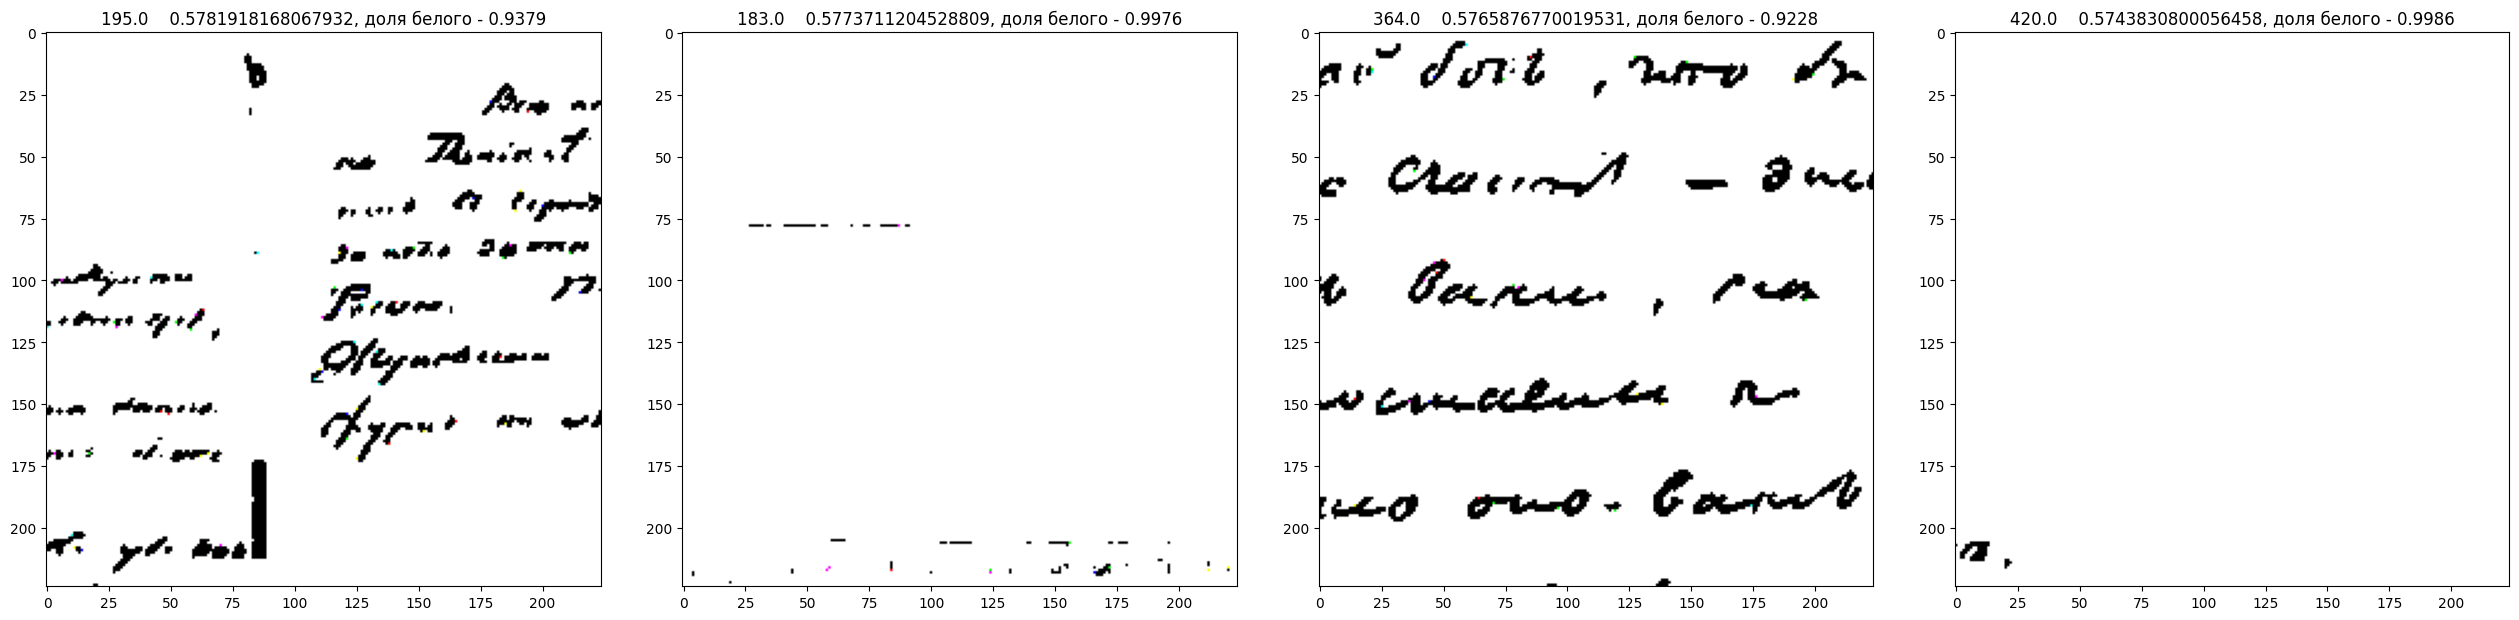

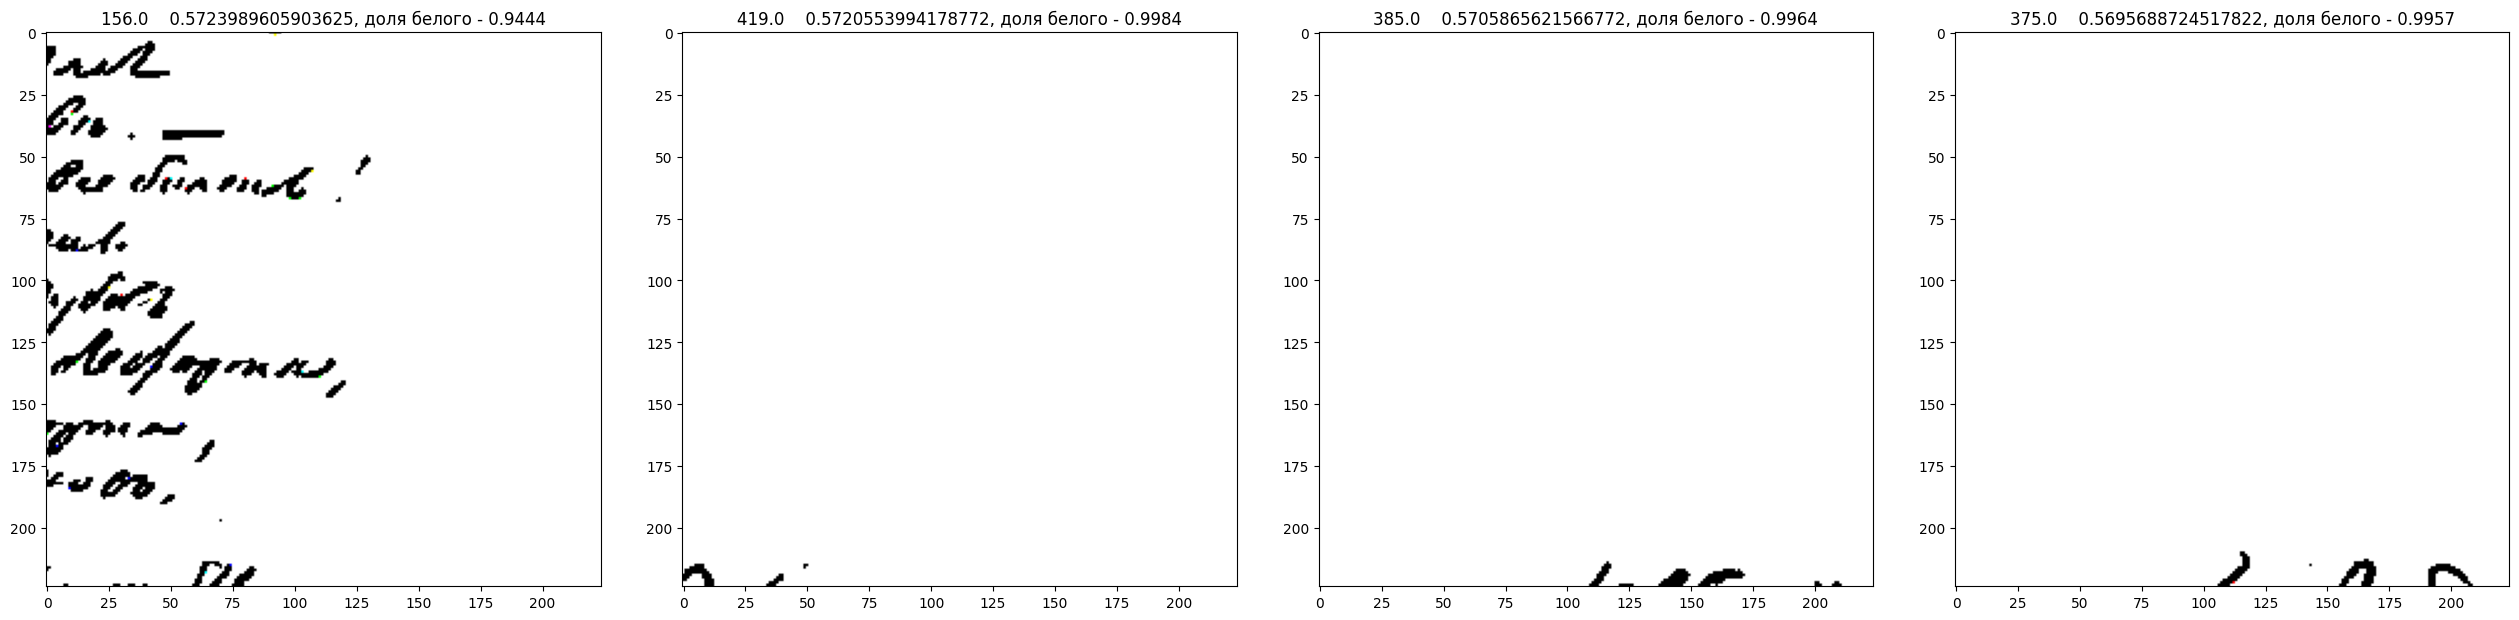

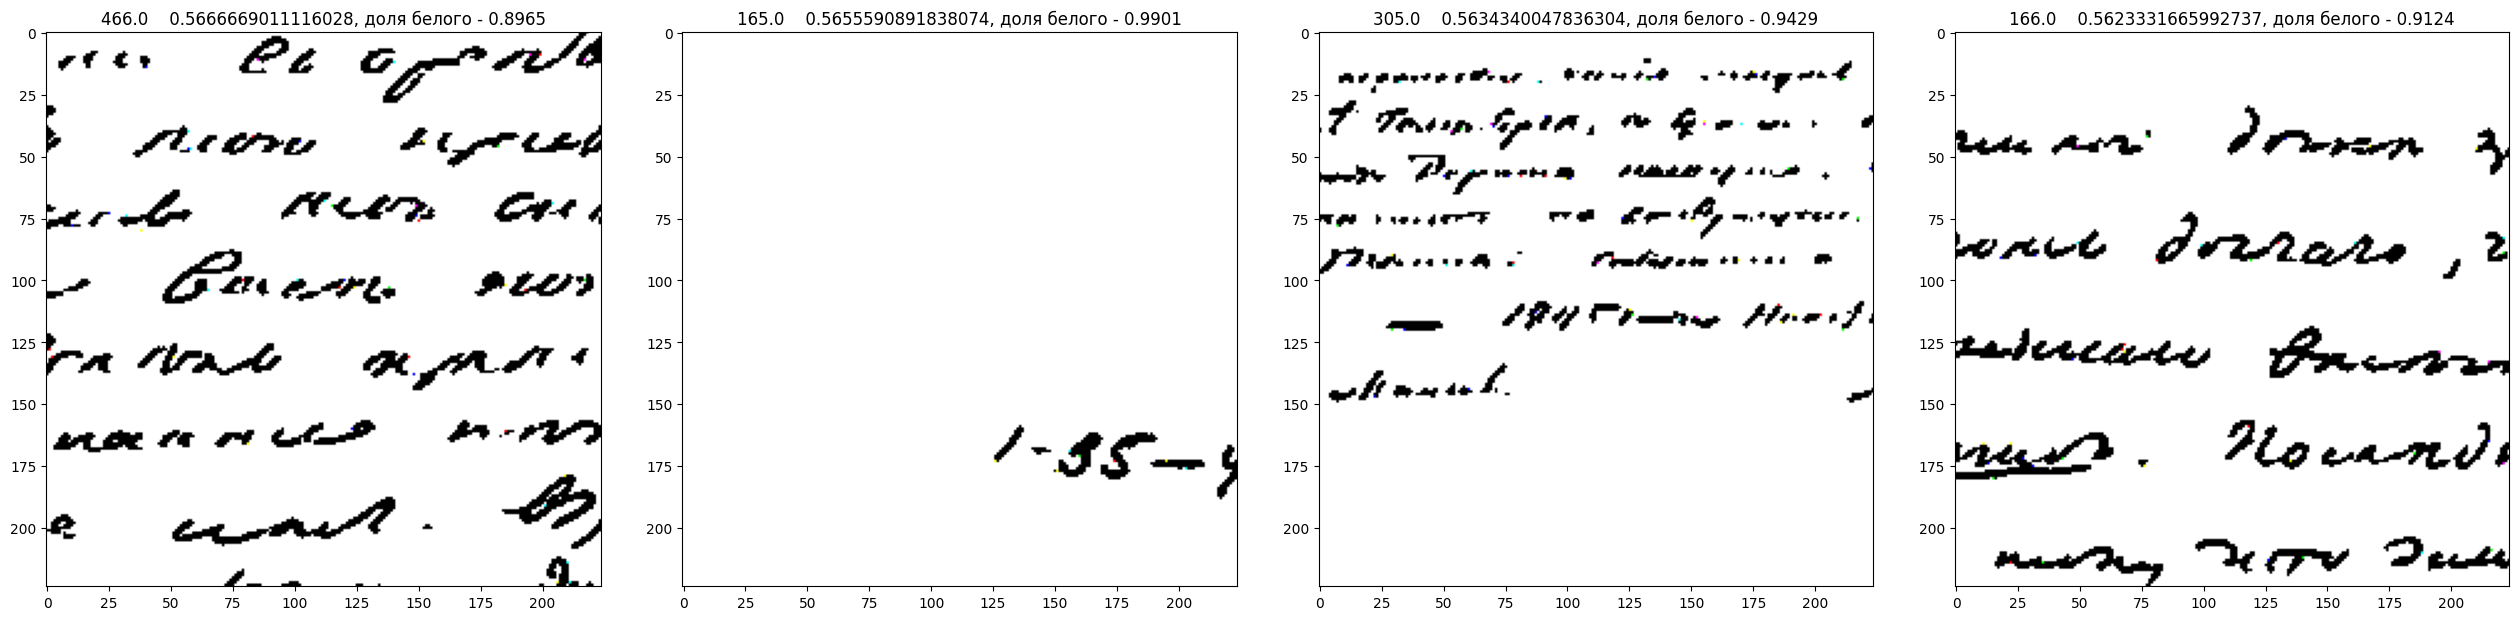

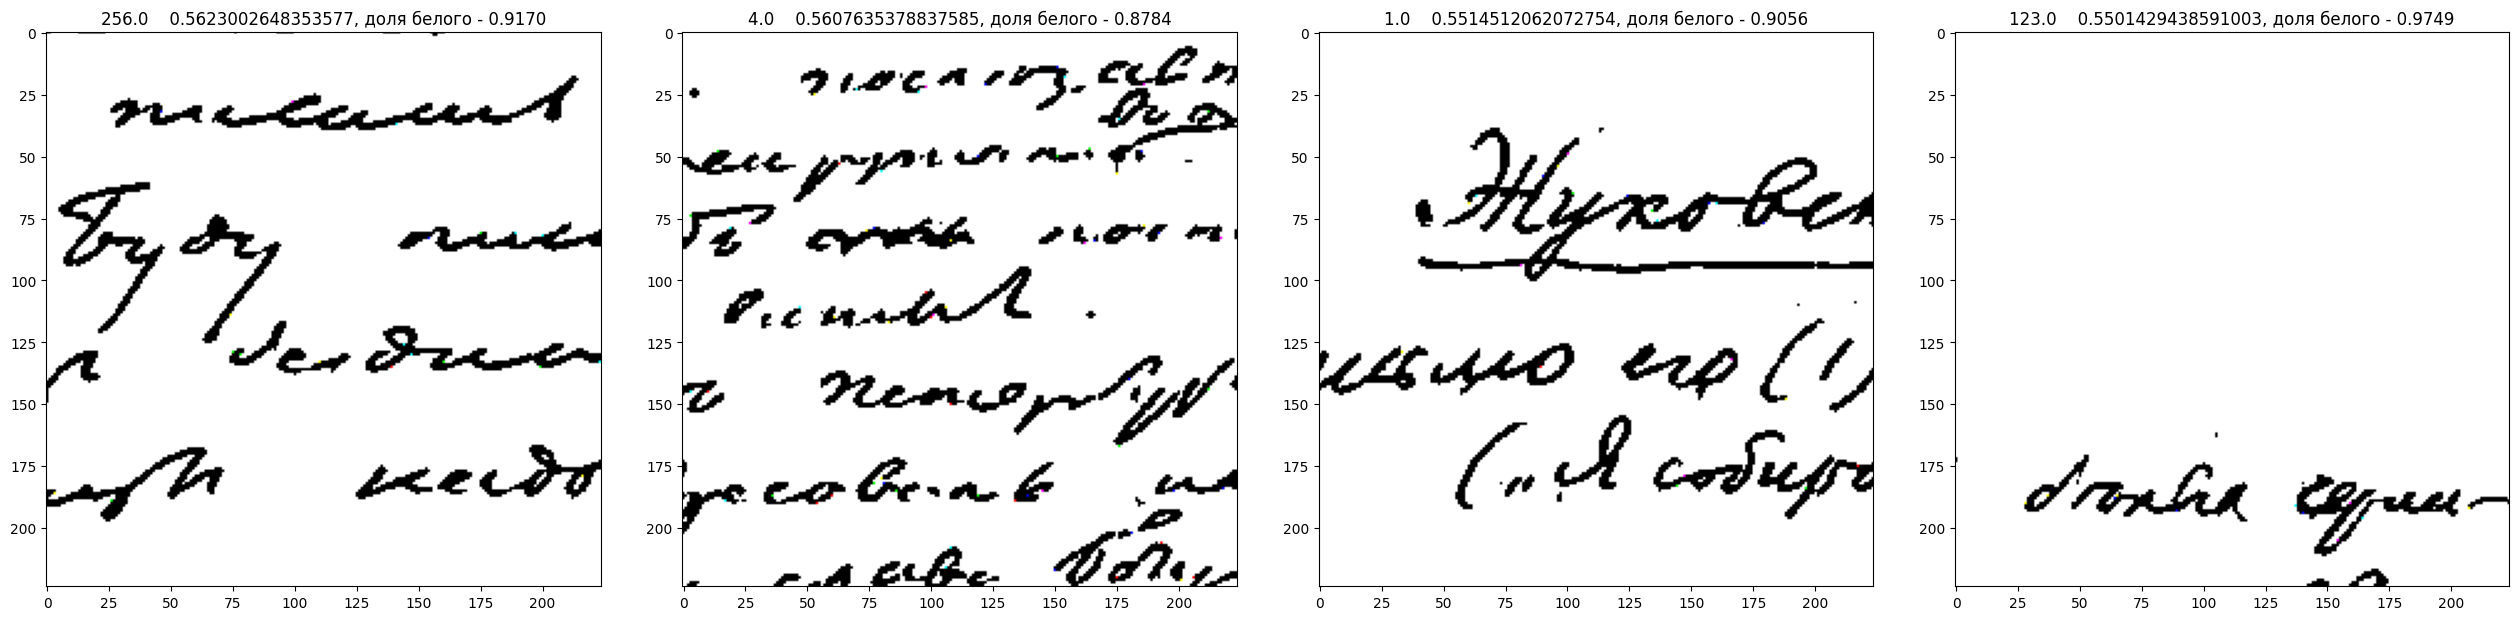

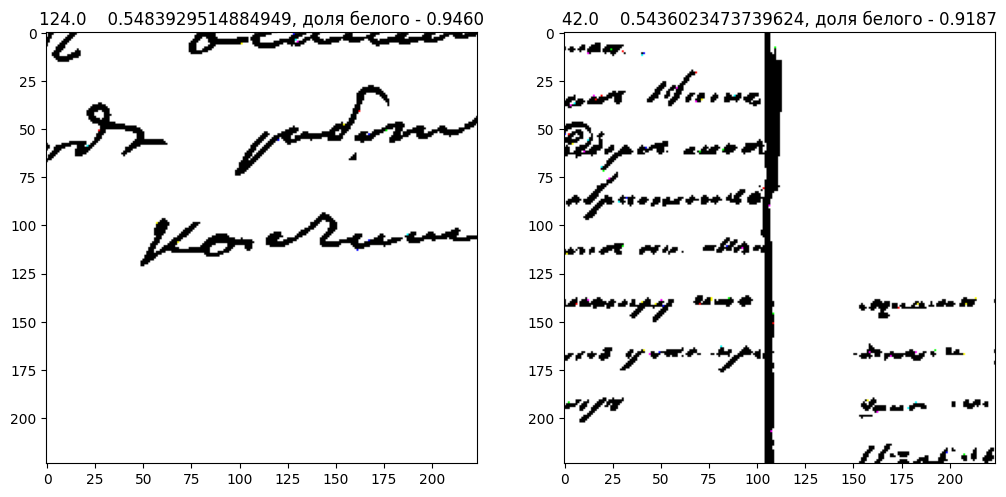

In [22]:
X, y_true, y_pred, y_prob, indices = show_result(model, pos_dataset, 0.6,
                                   CONF.loader.batch_size, CONF.device,
                                   greater = False, col = 30,
                                   sort = True)

prob > 0.4
count : 153 out of 448
pic idx : [253, 225, 100, 324, 289, 150, 201, 284, 54, 65, 369, 212, 355, 264, 358, 281, 403, 206, 318, 259, 287, 124, 41, 136]


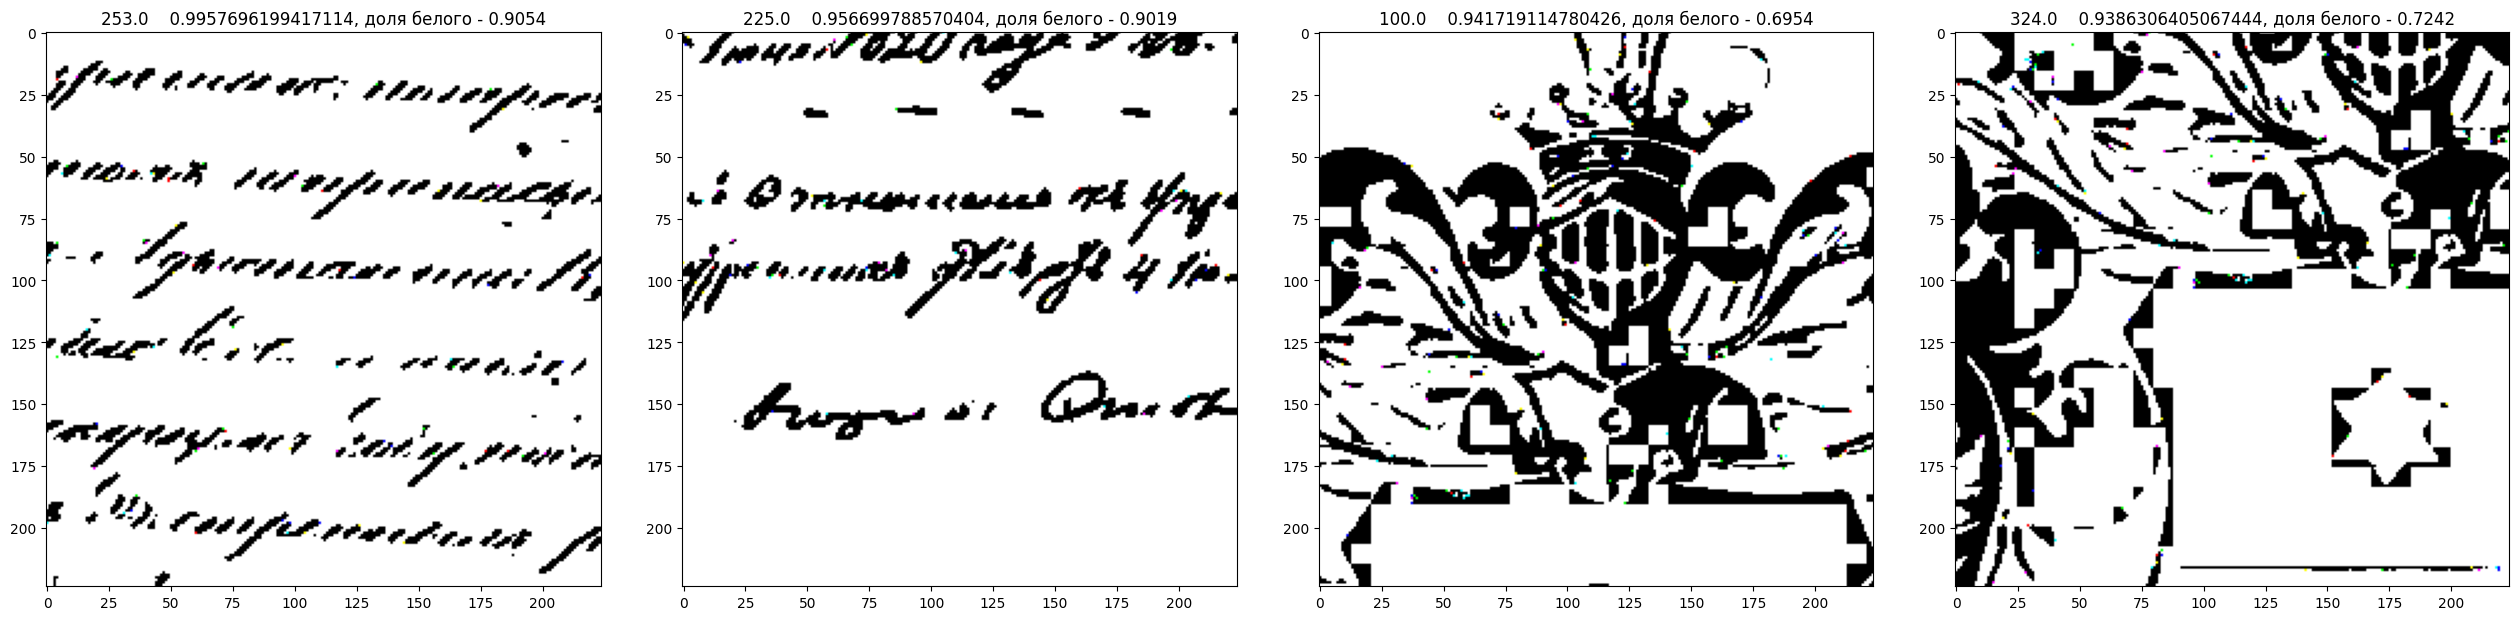

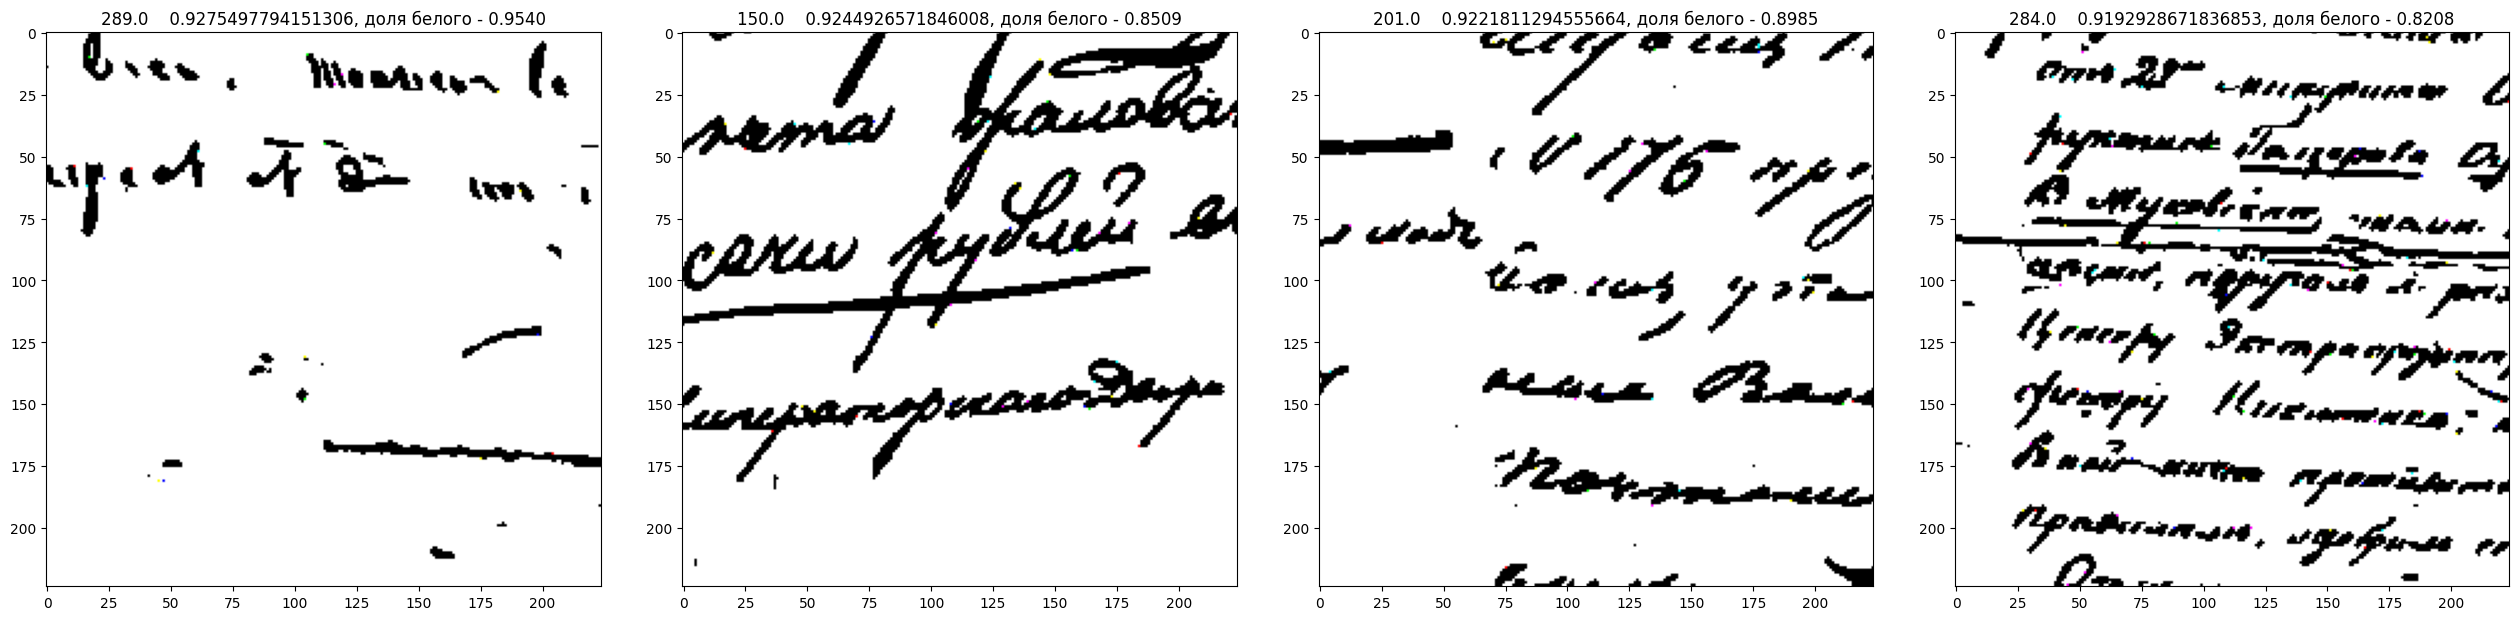

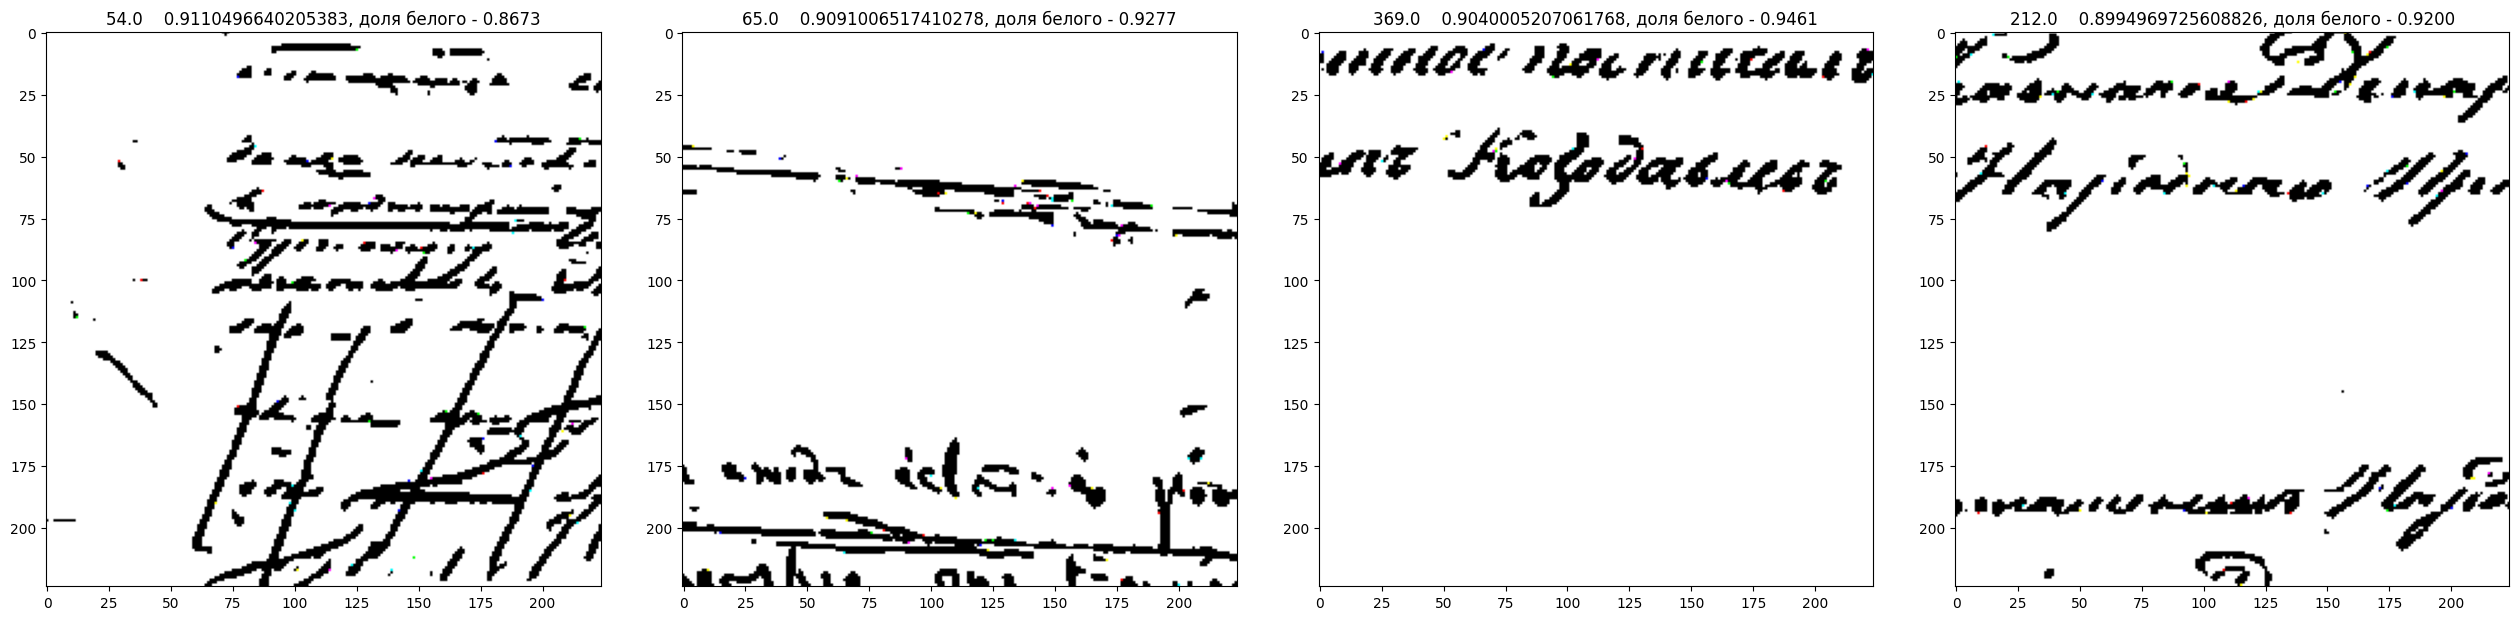

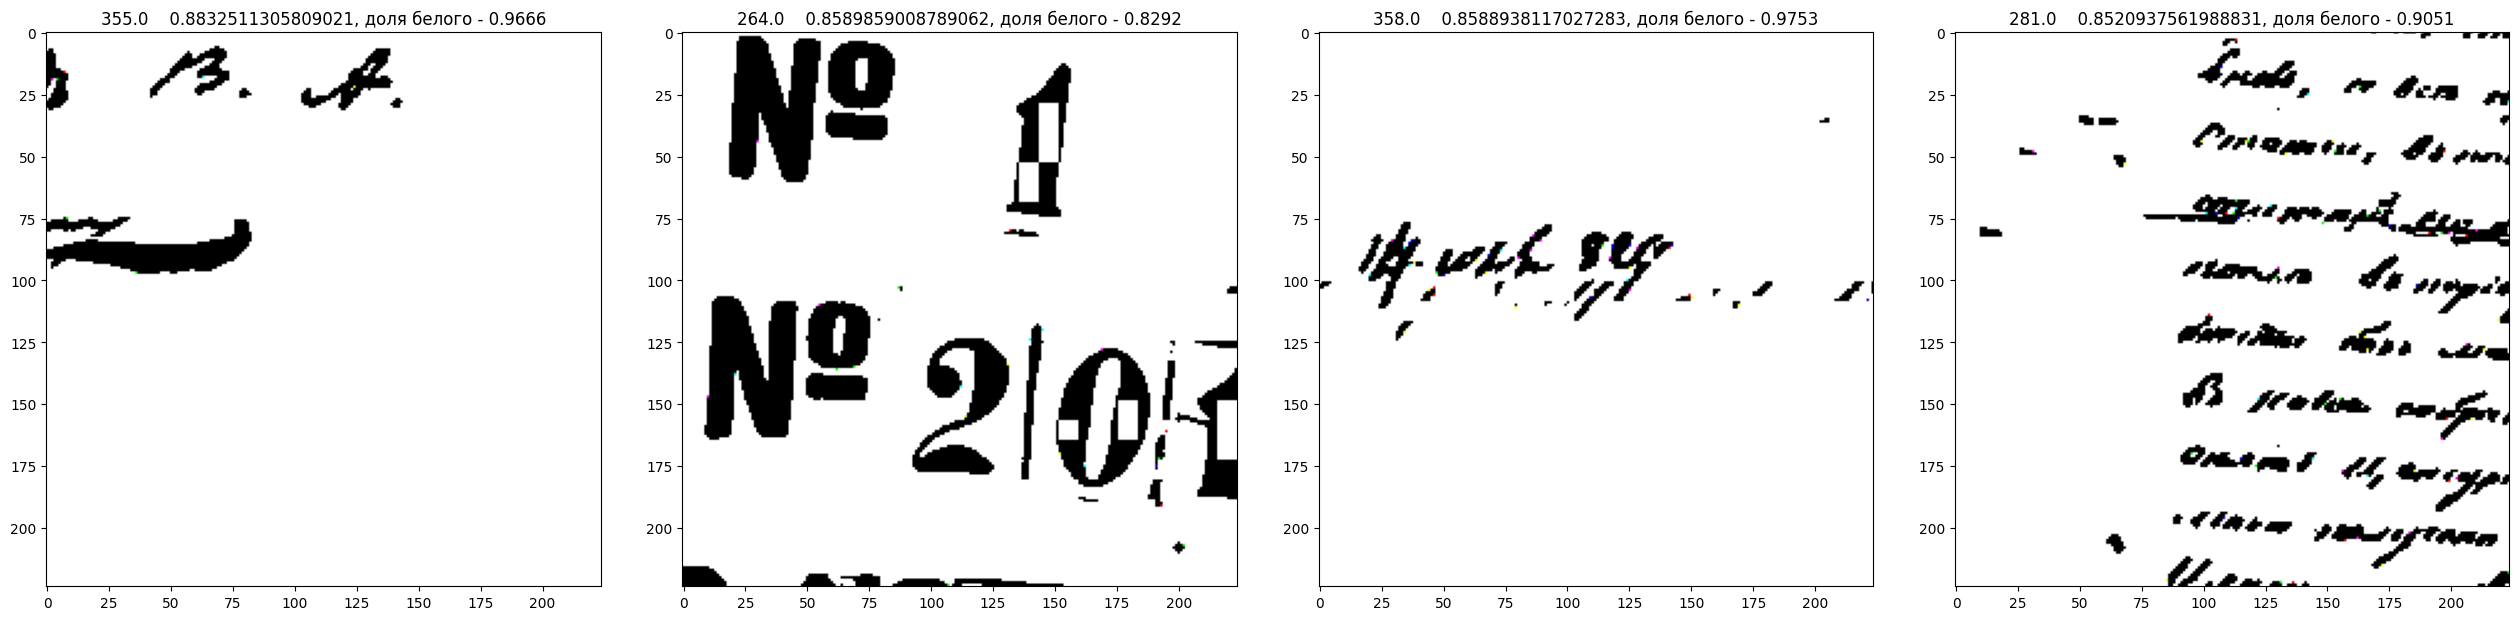

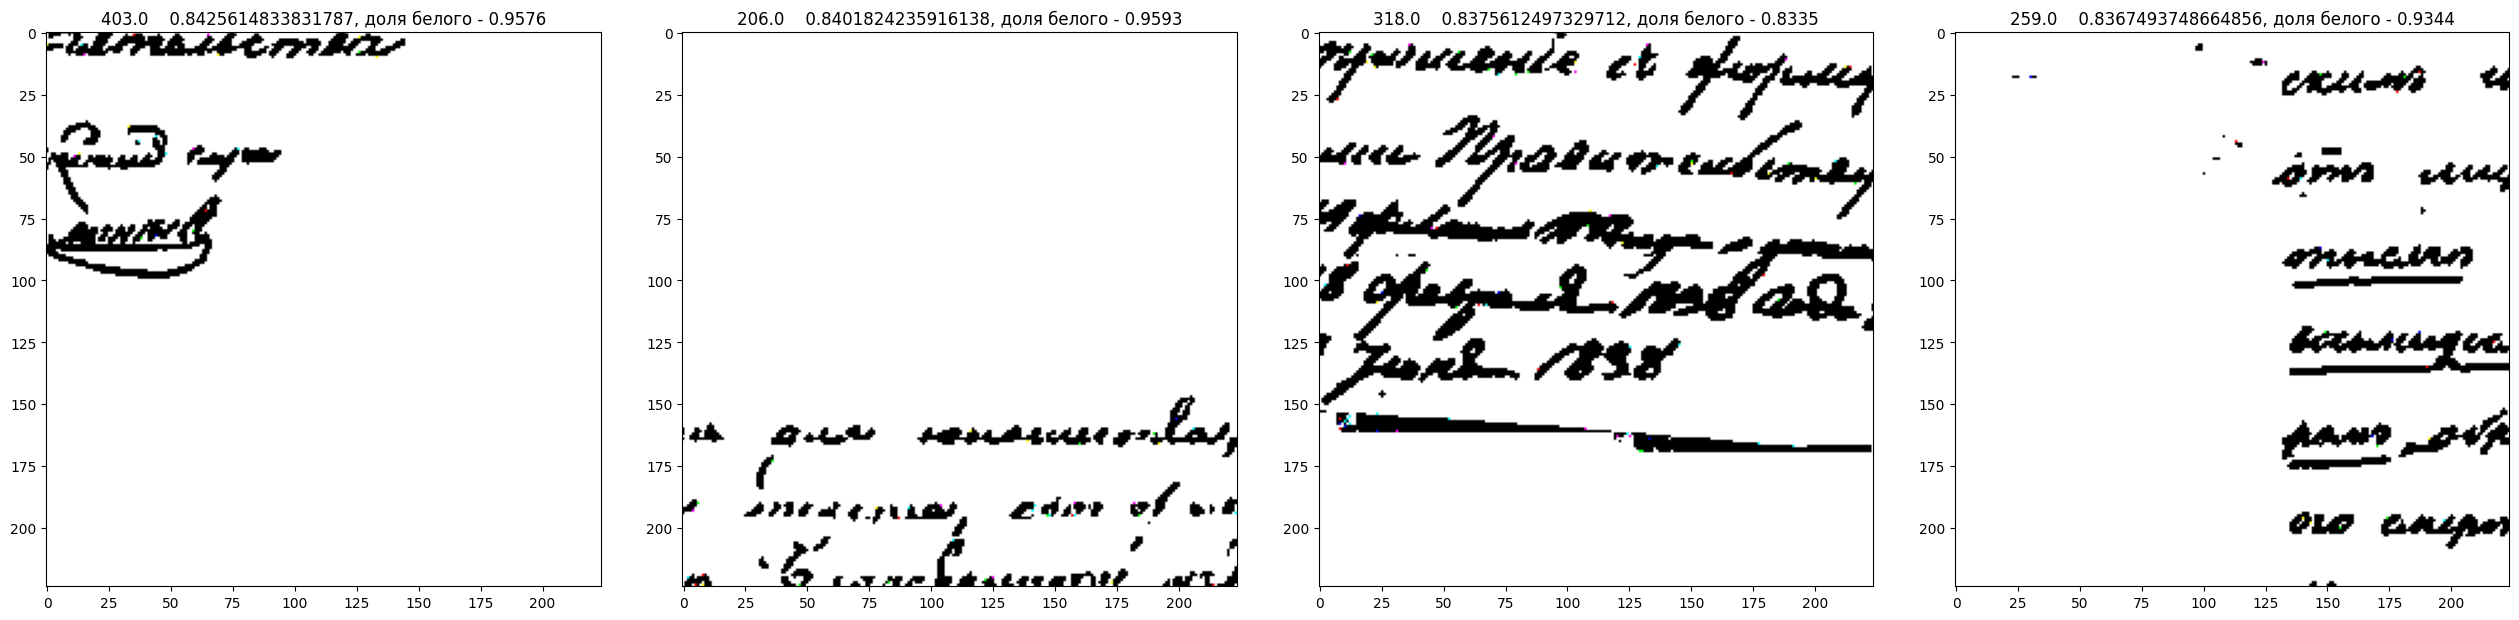

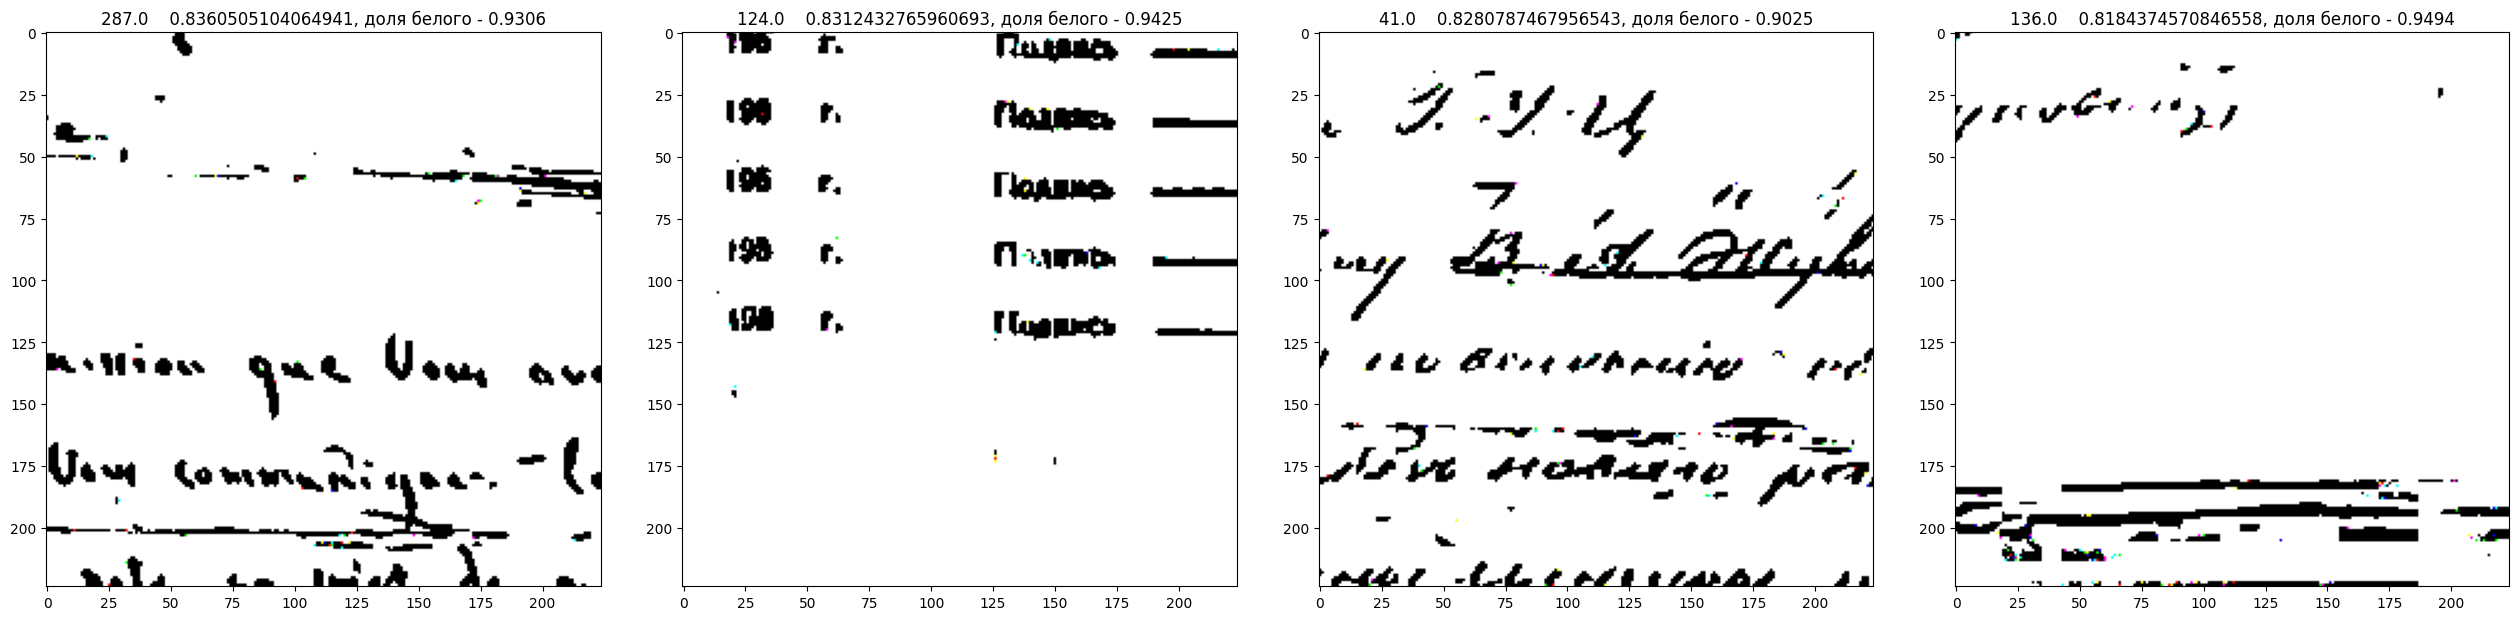

In [23]:
X, y_true, y_pred, y_prob, indices = show_result(model, neg_dataset, 0.4,
                                   CONF.loader.batch_size, CONF.device,
                                   greater = True, col = 24,
                                   sort = True)

# on the entire dataset

In [24]:
X, y_true, y_pred, y_prob, indices = show_result(model, neg_dataset, 0,
                                   CONF.loader.batch_size, CONF.device,
                                   greater = True, col = 448,
                                   sort = True)

Output hidden; open in https://colab.research.google.com to view.

In [25]:
X, y_true, y_pred, y_prob, indices = show_result(model, pos_dataset, 0,
                                   CONF.loader.batch_size, CONF.device,
                                   greater = True, col = 484,
                                   sort = True)

Output hidden; open in https://colab.research.google.com to view.